In [205]:
%load_ext autoreload
%autoreload 2

from src.sampling.main import stratified_spatial_sampling_dual
from dataset.weather_graph_dataset import WeatherGraphDatasetWithRadar

import torch
from torch_geometric.data import HeteroData
from src.raingauge.utils import (
    get_station_coordinate_mappings,
    load_weather_station_dataset,
)
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
from scipy.stats import pearsonr
from src.radar.utils import load_radar_dataset
from src.visualization.main import pandas_to_geodataframe, visualise_singapore_outline
from src.visualization.radar import (
    improved_visualise_radar_grid,
    visualize_one_radar_image_with_cropping,
    visualize_one_radar_image,
)
from src.visualization.raingauge import visualise_gauge_grid
import cartopy.crs as ccrs
import matplotlib as mpl
from src.radar.preprocessor import RadarPreprocessor
from scipy.spatial import cKDTree
from src.miscellaneous import get_straight_distance
from models.gnn_radar import HeteroGNN_WithRadar

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
# NOTE: Geographic extent of Singapore in longitude and latitude
bounds_singapore = {"left": 103.6, "right": 104.1, "top": 1.5, "bottom": 1.188}
bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20]
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend="both")

# Preprocess Radar Data

## Will find common data between radar and weather station

In [190]:
print("=== Radar Image Preprocessing ===\n")

# Load weather station data
# Assuming weather_station_df_pivot is available from your main script
# You'll need to load this from your saved data or regenerate it
try:
    weather_station_data = load_weather_station_dataset("weather_station_data.csv")
    weather_station_locations_raw = pd.read_csv(
        "database/weather_station_locations.csv"
    )

    # Filter for general stations
    weather_stations_df = weather_station_locations_raw[
        weather_station_locations_raw["gid"].isin(weather_station_data)
    ].copy()
    weather_stations_df = (
        weather_stations_df.set_index("gid").loc[weather_station_data].reset_index()
    )
    weather_station_locations = weather_station_locations_raw.set_index("gid").loc[
        weather_station_data
    ]

    cols = list(weather_stations_df.columns)
    cols.remove("time_sgt")
    cols.remove("gid")

    weather_station_df_pivot = (
        pd.pivot(data=weather_stations_df, index="time_sgt", columns="gid", values=cols)
        .resample("15min")
        .first()
    )

    print(f"Loaded weather station data: {weather_stations_df.shape[0]} timestamps")

except Exception as e:
    print(f"Error loading weather station data: {e}")
    print("Please ensure weather_station_data.csv is available")

# Initialize preprocessor
preprocessor = RadarPreprocessor(
    radar_base_path="database/sg_radar_data",
    output_path="database/sg_radar_data_cropped",
    weather_station_df=weather_station_df_pivot,
)

# Step 1: Get all radar files
print("\nStep 1: Scanning radar files...")
radar_files = preprocessor.get_all_radar_files()

if len(radar_files) == 0:
    print("No radar files found! Please check the radar_base_path.")

print(f"Found {len(radar_files)} radar files")
print(f"Date range: {radar_files[0][0]} to {radar_files[-1][0]}")

# Step 2: Match with weather data
print("\nStep 2: Matching with weather station data...")
matched_radar_df, matched_weather_df = preprocessor.match_with_weather_data(radar_files)

if len(matched_radar_df) == 0:
    raise ValueError("No matching timestamps found!")

# Step 3: Process and crop all matched files
print("\nStep 3: Cropping radar images to Singapore bounds...")
results_df = preprocessor.process_all_matched_files(matched_radar_df)

# Step 4: Save metadata
preprocessor.save_metadata(results_df)

# Save matched weather dataframe
matched_weather_path = preprocessor.output_path / "matched_weather_station_data.csv"
matched_weather_df.to_csv(matched_weather_path)
print(f"Matched weather station data saved to: {matched_weather_path}")

print("\n=== Preprocessing Complete ===")
print(f"Cropped radar images saved to: {preprocessor.output_path}")

=== Radar Image Preprocessing ===

Error loading weather station data: [Errno 2] No such file or directory: 'database/weather_station_locations.csv'
Please ensure weather_station_data.csv is available

Step 1: Scanning radar files...
Found 8334 radar files
Date range: 2025-02-01 00:00:00 to 2025-04-30 23:45:00

Step 2: Matching with weather station data...

=== Unmatched Radar Files ===
All radar files were matched.

=== Unmatched Weather Files ===
Found 402 unmatched weather files:
               timestamp  weather_idx
0    2025-01-30 00:00:00            0
1    2025-01-30 00:15:00            1
2    2025-01-30 00:30:00            2
3    2025-01-30 00:45:00            3
4    2025-01-30 01:00:00            4
5    2025-01-30 01:15:00            5
6    2025-01-30 01:30:00            6
7    2025-01-30 01:45:00            7
8    2025-01-30 02:00:00            8
9    2025-01-30 02:15:00            9
10   2025-01-30 02:30:00           10
11   2025-01-30 02:45:00           11
12   2025-01-30 03

Cropping radar images: 100%|██████████| 8334/8334 [00:14<00:00, 576.65it/s]



=== Processing Complete ===
Successfully processed: 8334/8334
Failed: 0

Metadata saved to: database/sg_radar_data_cropped/radar_preprocessing_metadata.csv
Matched weather station data saved to: database/sg_radar_data_cropped/matched_weather_station_data.csv

=== Preprocessing Complete ===
Cropped radar images saved to: database/sg_radar_data_cropped


The size of dataset is 8334
Data shape: (31, 50)
Data min: 0.0, max: 0.0, mean: 0.0
Non-zero values: 0 out of 1550


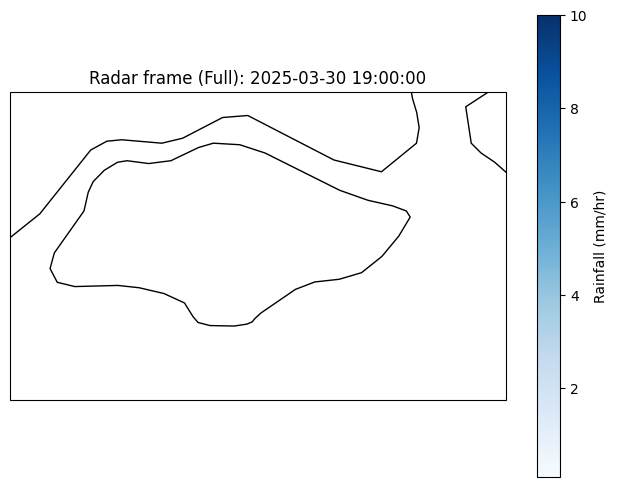

In [191]:
radar_df = load_radar_dataset("sg_radar_data_cropped", cropped=True)
visualize_one_radar_image(radar_df=radar_df, n=1)

# Preprocess Radar Station Data

In [ ]:
data = HeteroData()
dtype = torch.float32
radius_km = (
    1  # Depends on the radius we want to connect the radar grid to weather stations
)

# ---- 1) prepare station ID list
weather_station_df_pivot["rain_rate"] *= 12
station_ids = sorted({col[1] for col in weather_station_df_pivot.columns})

# ---- 2) count observations per variable/station
station_counts = weather_station_df_pivot.count().reset_index()
weather_station_info = pd.pivot(station_counts, index="gid", columns="level_0")

# ---- 3) prepare radar features
radar_features, grid_coords, grid_shape = preprocessor.prepare_radar_features_temporal(
    radar_df, weather_station_df_pivot
)

# ---- 4) classify rainfall vs general
rainfall_station = [
    gid for gid, row in weather_station_info.iterrows() if 0 in row.value_counts()
]

general_station = [
    s for s in weather_station_locations.keys() if s not in rainfall_station
]

# restrict to stations actually present
rainfall_station = [s for s in rainfall_station if s in weather_station_info.index]
general_station = [s for s in general_station if s in weather_station_info.index]

# ---- 5) build coordinate DF (always consistent)
loc_df = pd.DataFrame.from_dict(
    weather_station_locations, orient="index", columns=["latitude", "longitude"]
)

# ---- 6) flatten MultiIndex cols
df_all = weather_station_info.copy()
df_all.columns = [
    "_".join([str(c) for c in col])  # tuple -> join
    if isinstance(col, tuple)
    else str(col)  # normal -> stringify
    for col in df_all.columns
]

# split
df_rain = df_all.loc[rainfall_station].copy()
df_gen = df_all.loc[general_station].copy()

# ---- 7) attach coordinates (index matches)
df_all = df_all.join(loc_df)
df_rain = df_rain.join(loc_df)
df_gen = df_gen.join(loc_df)

# print(f"DF ALL: ",df_all.head())
# print(f"DF RAIN: ",df_rain.head())
# print(f"DF GEN: ",df_gen.head())

# ---- 8) numpy coordinate arrays
rain_coords = df_rain[["latitude", "longitude"]].to_numpy()
gen_coords = df_gen[["latitude", "longitude"]].to_numpy()
all_coords = df_all[["latitude", "longitude"]].to_numpy()

# Convert radius to degrees
# 111.0 km per degree is approximate conversion for latitude
radius_deg = radius_km / 111.0

# ---- 9) Radar to general stations
tree_gen = cKDTree(gen_coords)
radar_to_gen_list = tree_gen.query_ball_point(grid_coords, r=radius_deg)
radar_to_gen_src = []
radar_to_gen_dst = []
radar_to_gen_distances = []

for grid_idx, station_list in enumerate(radar_to_gen_list):
    for station_idx in station_list:
        # Use the same distance function as station-to-station edges
        dist = get_straight_distance(
            grid_coords[grid_idx],  # [lat, lon]
            gen_coords[station_idx],  # [lat, lon]
        )
        if dist <= radius_km:
            radar_to_gen_src.append(grid_idx)
            radar_to_gen_dst.append(station_idx)
            radar_to_gen_distances.append([dist])

print(f"Radar to general station connections: {len(radar_to_gen_src)}")

# ---- 10) Radar to rainfall stations
tree_rain = cKDTree(rain_coords)
radar_to_rain_list = tree_rain.query_ball_point(grid_coords, r=radius_deg)
radar_to_rain_src = []
radar_to_rain_dst = []
radar_to_rain_distances = []

for grid_idx, station_list in enumerate(radar_to_rain_list):
    for station_idx in station_list:
        dist = get_straight_distance(
            grid_coords[grid_idx],  # [lat, lon]
            rain_coords[station_idx],  # [lat, lon]
        )
        if dist <= radius_km:
            radar_to_rain_src.append(grid_idx)
            radar_to_rain_dst.append(station_idx)
            radar_to_rain_distances.append([dist])

print(f"Radar to rainfall station connections: {len(radar_to_rain_src)}")

# TODO: Since radar grids are not prediction targets, it's latent features / spatial context providers, not necessary to have radar to radar edges
# ---- 11) Radar to radar edges (radius-based, not connectivity-based)
# radar_to_radar_edges = preprocessor.create_grid_edges_radius(grid_coords, radius_km)
# print(f"Radar to radar edges: {radar_to_radar_edges.shape[1]} edges created")
# print(f"First 10 radar-radar edges:\n{radar_to_radar_edges[:, :10]}")

# ---- 12) Add radar node features to HeteroData
data["radar_grid"].x = torch.tensor(radar_features, dtype=dtype)
data["radar_grid"].y = torch.tensor(radar_features, dtype=dtype)

# ---- 13) Add edges (with empty array handling)
# Radar to general stations
if len(radar_to_gen_src) > 0:
    data["radar_grid", "radar_to_gen", "general_station"].edge_index = torch.tensor(
        np.array([radar_to_gen_src, radar_to_gen_dst]), dtype=torch.long
    )
    data["general_station", "gen_to_radar", "radar_grid"].edge_index = torch.tensor(
        np.array([radar_to_gen_dst, radar_to_gen_src]), dtype=torch.long
    )
    # Add distance attributes
    data["radar_grid", "radar_to_gen", "general_station"].edge_attr = torch.tensor(
        radar_to_gen_distances, dtype=dtype
    )
    data["general_station", "gen_to_radar", "radar_grid"].edge_attr = torch.tensor(
        radar_to_gen_distances, dtype=dtype
    )
else:
    print("WARNING: No radar to general station edges found within radius")
    data["radar_grid", "radar_to_gen", "general_station"].edge_index = torch.empty(
        (2, 0), dtype=torch.long
    )
    data["general_station", "gen_to_radar", "radar_grid"].edge_index = torch.empty(
        (2, 0), dtype=torch.long
    )
    data["radar_grid", "radar_to_gen", "general_station"].edge_attr = torch.empty(
        (0, 1), dtype=dtype
    )
    data["general_station", "gen_to_radar", "radar_grid"].edge_attr = torch.empty(
        (0, 1), dtype=dtype
    )

# Radar to rainfall stations
if len(radar_to_rain_src) > 0:
    data["radar_grid", "radar_to_rain", "rainfall_station"].edge_index = torch.tensor(
        np.array([radar_to_rain_src, radar_to_rain_dst]), dtype=torch.long
    )
    data["rainfall_station", "rain_to_radar", "radar_grid"].edge_index = torch.tensor(
        np.array([radar_to_rain_dst, radar_to_rain_src]), dtype=torch.long
    )
    # Add distance attributes
    data["radar_grid", "radar_to_rain", "rainfall_station"].edge_attr = torch.tensor(
        radar_to_rain_distances, dtype=dtype
    )
    data["rainfall_station", "rain_to_radar", "radar_grid"].edge_attr = torch.tensor(
        radar_to_rain_distances, dtype=dtype
    )
else:
    print("WARNING: No radar to rainfall station edges found within radius")
    data["radar_grid", "radar_to_rain", "rainfall_station"].edge_index = torch.empty(
        (2, 0), dtype=torch.long
    )
    data["rainfall_station", "rain_to_radar", "radar_grid"].edge_index = torch.empty(
        (2, 0), dtype=torch.long
    )
    data["radar_grid", "radar_to_rain", "rainfall_station"].edge_attr = torch.empty(
        (0, 1), dtype=dtype
    )
    data["rainfall_station", "rain_to_radar", "radar_grid"].edge_attr = torch.empty(
        (0, 1), dtype=dtype
    )

# ---- 14) Add masks for radar nodes
n_radar_nodes = len(grid_coords)
data["radar_grid"].train_mask = [1 for _ in range(n_radar_nodes)]
data["radar_grid"].val_mask = [1 for _ in range(n_radar_nodes)]
data["radar_grid"].test_mask = [1 for _ in range(n_radar_nodes)]

# ---- 15) Summary
print("\n=== Radar Grid Integration Summary ===")
print(f"Radar grid nodes: {n_radar_nodes}")
print(f"Grid shape: {grid_shape[0]} x {grid_shape[1]}")
print(f"Timesteps: {radar_features.shape[0]}")
print(f"Radar to general station edges: {len(radar_to_gen_src)}")
print(f"Radar to rainfall station edges: {len(radar_to_rain_src)}")
print(f"Station connection radius: {radius_km} km")
print(f"Grid connection radius: {radius_km} km")
print("=" * 40)

print("Radar Features: ", radar_features.shape)


Radar to general station connections: 31
Radar to rainfall station connections: 111

=== Radar Grid Integration Summary ===
Radar grid nodes: 1550
Grid shape: 31 x 50
Timesteps: 8736
Radar to general station edges: 31
Radar to rainfall station edges: 111
Station connection radius: 1 km
Grid connection radius: 1 km
Radar Features:  (8736, 1550, 1)


# Preprocess station data.
Some stations only contain rainfall information but some stations contain both rainfall and other information.
We will split these stations into weather station and general stations 

Additional info: 
  Windspeed
  Wind Direction
  Temperature
  Relative Humidity

In [193]:
general_station_data = {}
rainfall_station_data = {}

# Extract and interpolate station data
for station in weather_station_df_pivot.columns.get_level_values(1).unique():
    station_cols = (
        weather_station_df_pivot.xs(station, level=1, axis=1)
        .interpolate(method="linear")
        .fillna(method="ffill")
        .fillna(method="bfill")
    )
    if station in general_station:
        general_station_data[station] = station_cols.values
    else:
        rainfall_station_data[station] = station_cols.values[:, 0:1]

# Prepare features in the correct order
general_station_features = []
rainfall_station_features = []

for station in general_station:
    station_feat = general_station_data[station]
    general_station_features.append(station_feat)

for station in rainfall_station:
    station_feat = rainfall_station_data[station]
    rainfall_station_features.append(station_feat)

/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_6640/408671881.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_station_df_pivot.xs(station, level=1, axis=1)
/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_6640/408671881.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_station_df_pivot.xs(station, level=1, axis=1)
/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_6640/408671881.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_station_df_pivot.xs(station, level=1, axis=1)
/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_6640/408671881.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.

In [194]:
# Add station features to HeteroData
data["general_station"].x = torch.tensor(
    np.array(general_station_features).transpose(1, 0, 2), dtype=dtype
)
data["rainfall_station"].x = torch.tensor(
    np.array(rainfall_station_features).transpose(1, 0, 2), dtype=dtype
)

# Add station targets
data["general_station"].y = torch.tensor(
    np.array(general_station_features)[:, :, 0:1].transpose(1, 0, 2), dtype=dtype
)
data["rainfall_station"].y = torch.tensor(
    np.array(rainfall_station_features).transpose(1, 0, 2), dtype=dtype
)

print(data)
print("\n=== Station Features Added ===")
print(f"General station features shape: {data['general_station'].x.shape}")
print(f"Rainfall station features shape: {data['rainfall_station'].x.shape}")

HeteroData(
  radar_grid={
    x=[8736, 1550, 1],
    y=[8736, 1550, 1],
    train_mask=[1550],
    val_mask=[1550],
    test_mask=[1550],
  },
  general_station={
    x=[8736, 15, 5],
    y=[8736, 15, 1],
  },
  rainfall_station={
    x=[8736, 48, 1],
    y=[8736, 48, 1],
  },
  (radar_grid, radar_to_gen, general_station)={
    edge_index=[2, 31],
    edge_attr=[31, 1],
  },
  (general_station, gen_to_radar, radar_grid)={
    edge_index=[2, 31],
    edge_attr=[31, 1],
  },
  (radar_grid, radar_to_rain, rainfall_station)={
    edge_index=[2, 111],
    edge_attr=[111, 1],
  },
  (rainfall_station, rain_to_radar, radar_grid)={
    edge_index=[2, 111],
    edge_attr=[111, 1],
  }
)

=== Station Features Added ===
General station features shape: torch.Size([8736, 15, 5])
Rainfall station features shape: torch.Size([8736, 48, 1])


K-MEANS STRATIFIED SPATIAL SAMPLING
Total stations: 64
Number of clusters: 8
Random seed: 1111

Split configuration:
  - Test (shared): 10%
  - Statistical train: 90%
  - ML train: 70%
  - ML validation: 20%

STEP 1: K-means Clustering
Clustering complete. Cluster centers:
  Cluster 0: (103.7499, 1.3548) - 6 stations
  Cluster 1: (103.8842, 1.3875) - 7 stations
  Cluster 2: (103.9656, 1.3530) - 9 stations
  Cluster 3: (103.8819, 1.3103) - 8 stations
  Cluster 4: (103.7632, 1.4335) - 7 stations
  Cluster 5: (103.6780, 1.3101) - 5 stations
  Cluster 6: (103.8000, 1.2868) - 15 stations
  Cluster 7: (103.8388, 1.3588) - 7 stations

STEP 2: Creating Shared Test Set (10%)
  Cluster 0: 6 stations → 1 test, 5 remaining
  Cluster 1: 7 stations → 1 test, 6 remaining
  Cluster 2: 9 stations → 1 test, 8 remaining
  Cluster 3: 8 stations → 1 test, 7 remaining
  Cluster 4: 7 stations → 1 test, 6 remaining
  Cluster 5: 5 stations → 1 test, 4 remaining
  Cluster 6: 15 stations → 1 test, 14 remaining
 

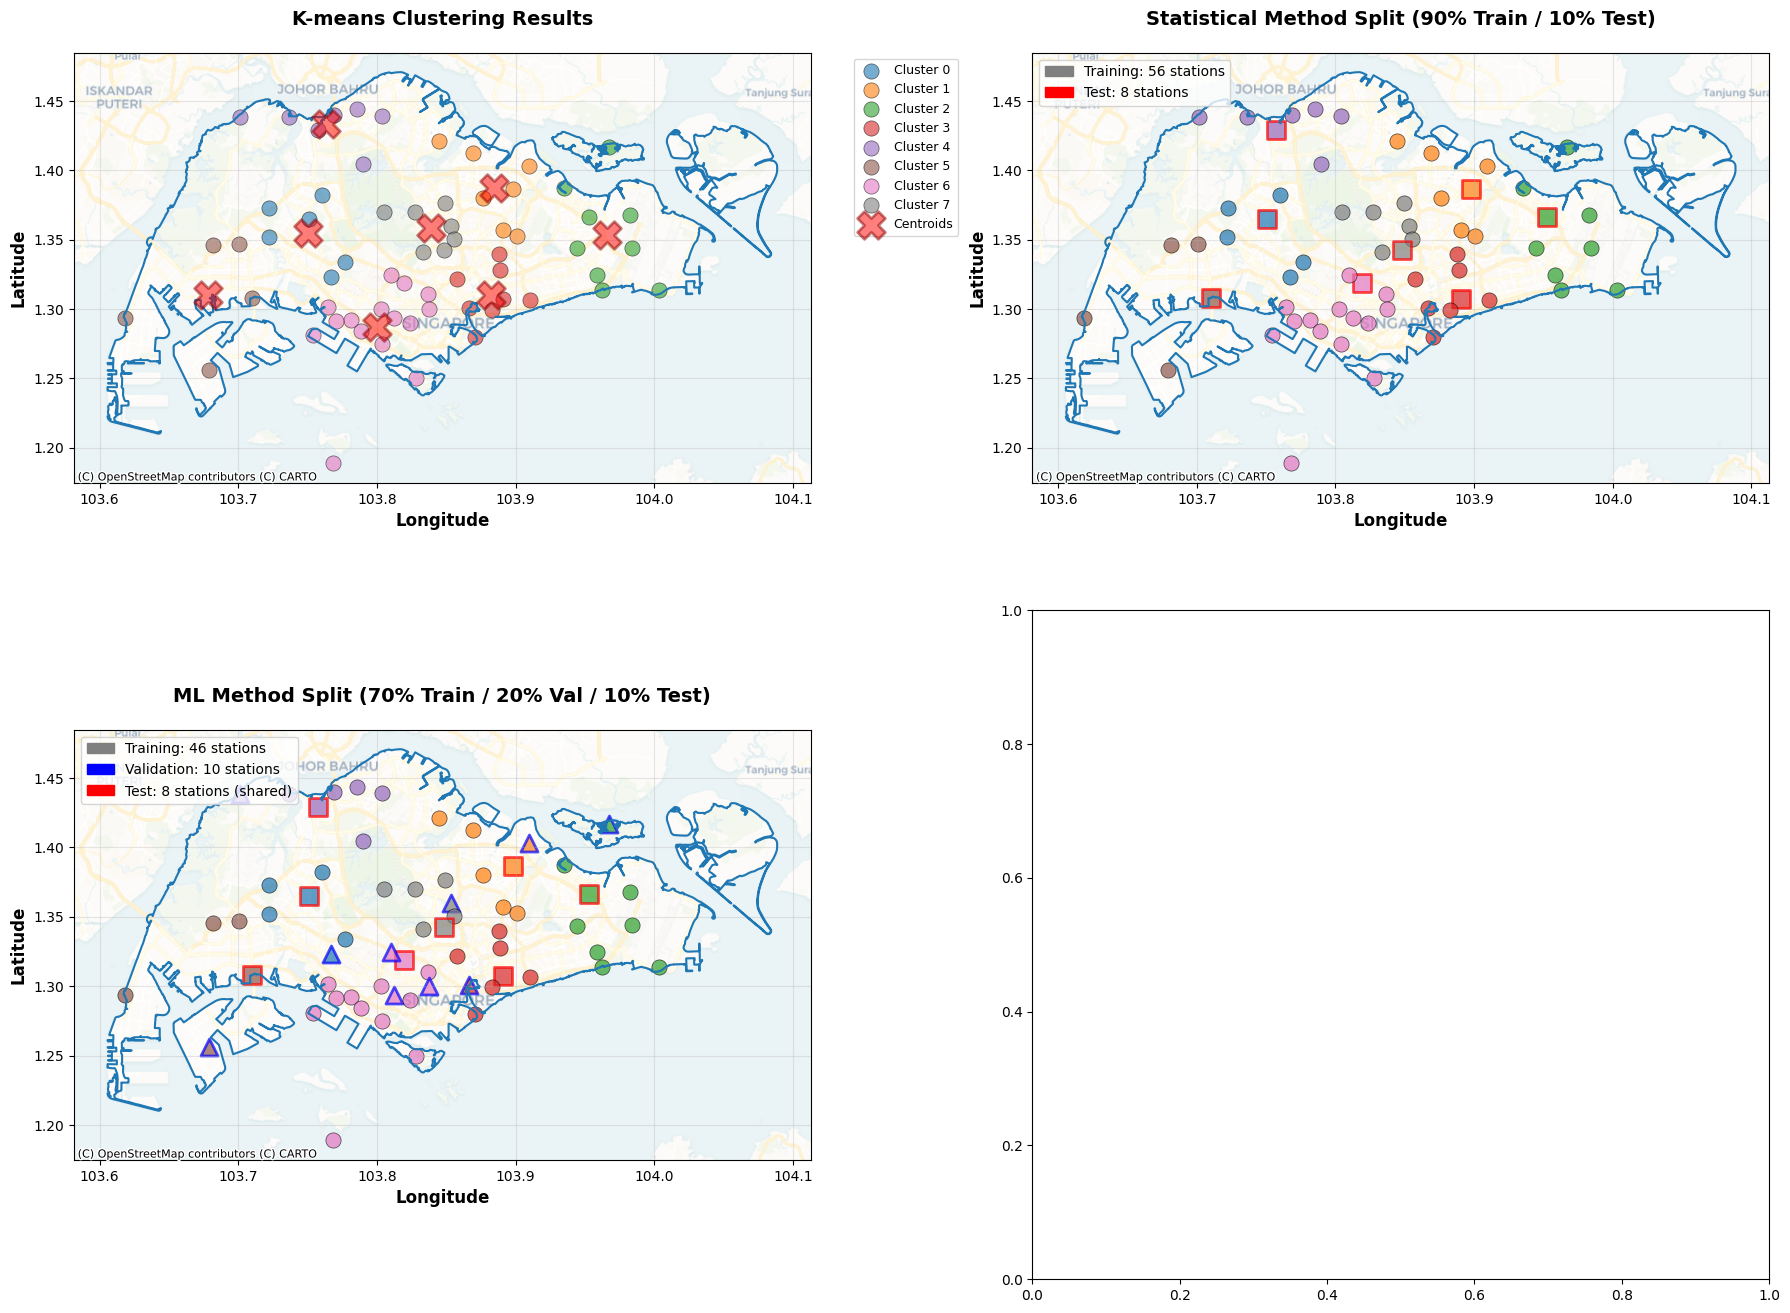

{'statistical': {'train': array(['S201', 'S64', 'S50', 'S121', 'S229', 'S81', 'S221', 'S209',
       'S900', 'S06', 'S219', 'S107', 'S224', 'S24', 'S106', 'S84',
       'S207', 'S208', 'S29', 'S108', 'S214', 'S215', 'S123', 'S119',
       'S113', 'S43', 'S40', 'S210', 'S112', 'S66', 'S227', 'S104',
       'S115', 'S44', 'S228', 'S117', 'S60', 'S79', 'S116', 'S71', 'S102',
       'S222', 'S213', 'S111', 'S226', 'S223', 'S203', 'S92', 'S230',
       'S77', 'S109', 'S217', 'S216', 'S07', 'S08', 'S69'], dtype='<U4'), 'test': array(['S218', 'S220', 'S94', 'S78', 'S211', 'S33', 'S90', 'S88'],
      dtype='<U4')}, 'ml': {'train': array(['S50', 'S229', 'S64', 'S121', 'S06', 'S219', 'S209', 'S900',
       'S221', 'S208', 'S84', 'S207', 'S24', 'S29', 'S224', 'S107',
       'S113', 'S43', 'S108', 'S123', 'S214', 'S215', 'S210', 'S66',
       'S40', 'S104', 'S227', 'S228', 'S44', 'S115', 'S60', 'S92', 'S102',
       'S116', 'S230', 'S222', 'S71', 'S226', 'S111', 'S203', 'S223',
       'S217', 'S10

In [195]:
split_info = stratified_spatial_sampling_dual(weather_station_locations, seed=1111)
print(split_info)

data["general_station"].train_mask = [
    1 if station in split_info["ml"]["train"] else 0 for station in general_station
]
data["general_station"].val_mask = [
    1 if station in split_info["ml"]["validation"] else 0 for station in general_station
]
data["general_station"].test_mask = [
    1 if (x == 0 and y == 0) else 0
    for x, y in zip(
        data["general_station"].train_mask, data["general_station"].val_mask
    )
]

data["rainfall_station"].train_mask = [
    1 if station in split_info["ml"]["train"] else 0 for station in rainfall_station
]
data["rainfall_station"].val_mask = [
    1 if station in split_info["ml"]["validation"] else 0
    for station in rainfall_station
]
data["rainfall_station"].test_mask = [
    1 if (x == 0 and y == 0) else 0
    for x, y in zip(
        data["rainfall_station"].train_mask, data["rainfall_station"].val_mask
    )
]

print(data)

# Edge generation
We consider the location of the stations when performing our edge generation. 
General station locations and rainfall station locations will be considered the same and we will make a connection across the nodes if required. This will ensure that we can connect both the layers together in the graph.

In [196]:
K = 4  # Number of neighbors per node

ids = general_station + rainfall_station
print(f"\nTotal stations for KNN: {len(ids)}")

coordinates = []
for id in ids:
    coordinates.append(weather_station_locations[id])
coords = np.array(coordinates)

knn = NearestNeighbors(n_neighbors=K + 1, algorithm="ball_tree")
knn.fit(coords)

distances, indices = knn.kneighbors(coords)

G = nx.Graph()

edges = {
    "rainfall_to_rainfall": [],
    "rainfall_to_general": [],
    "general_to_rainfall": [],
    "general_to_general": [],
}

edge_attributes = {
    "rainfall_to_rainfall": [],
    "rainfall_to_general": [],
    "general_to_rainfall": [],
    "general_to_general": [],
}

# Add station coordinates for nx plotting
for idx, station in enumerate(general_station + rainfall_station):
    G.add_node(
        idx,
        pos=(
            weather_station_locations[station][1],
            weather_station_locations[station][0],
        ),
    )

color_map = ["green" for i in range(len(general_station))] + [
    "red" for i in range(len(rainfall_station))
]

# Build edges
for idx, row in enumerate(indices):
    origin = row[0]

    for n in row[1:]:
        G.add_edge(origin, n)
        if ids[origin] in rainfall_station:
            start_id = rainfall_station.index(ids[origin])
            if ids[n] in rainfall_station:
                end_id = rainfall_station.index(ids[n])
                edges["rainfall_to_rainfall"].append([start_id, end_id])
                edge_attributes["rainfall_to_rainfall"].append(
                    [
                        get_straight_distance(
                            weather_station_locations[ids[origin]],
                            weather_station_locations[ids[n]],
                        )
                    ]
                )
            else:
                end_id = general_station.index(ids[n])
                edges["rainfall_to_general"].append([start_id, end_id])
                edge_attributes["rainfall_to_general"].append(
                    [
                        get_straight_distance(
                            weather_station_locations[ids[origin]],
                            weather_station_locations[ids[n]],
                        )
                    ]
                )
        else:
            start_id = general_station.index(ids[origin])
            if ids[n] in rainfall_station:
                end_id = rainfall_station.index(ids[n])
                edges["general_to_rainfall"].append([start_id, end_id])
                edge_attributes["general_to_rainfall"].append(
                    [
                        get_straight_distance(
                            weather_station_locations[ids[origin]],
                            weather_station_locations[ids[n]],
                        )
                    ]
                )
            else:
                end_id = general_station.index(ids[n])
                edges["general_to_general"].append([start_id, end_id])
                edge_attributes["general_to_general"].append(
                    [
                        get_straight_distance(
                            weather_station_locations[ids[origin]],
                            weather_station_locations[ids[n]],
                        )
                    ]
                )

print(f"\nGraph info: {G}")
print(f"Connected components: {len(list(nx.connected_components(G)))}")

# Convert edge lists to proper format
for key, val in edges.items():
    xarr = []
    yarr = []
    for x, y in val:
        xarr.append(x)
        yarr.append(y)
    edges[key] = [xarr, yarr]

# Add station-to-station edges
data["general_station", "gen_to_rain", "rainfall_station"].edge_index = torch.tensor(
    edges["general_to_rainfall"], dtype=torch.long
)
data["rainfall_station", "rain_to_gen", "general_station"].edge_index = torch.tensor(
    edges["rainfall_to_general"], dtype=torch.long
)
data["general_station", "gen_to_gen", "general_station"].edge_index = torch.tensor(
    edges["general_to_general"], dtype=torch.long
)
data["rainfall_station", "rain_to_rain", "rainfall_station"].edge_index = torch.tensor(
    edges["rainfall_to_rainfall"], dtype=torch.long
)

# Add edge attributes
data["general_station", "gen_to_rain", "rainfall_station"].edge_attr = torch.tensor(
    edge_attributes["general_to_rainfall"], dtype=dtype
)
data["rainfall_station", "rain_to_gen", "general_station"].edge_attr = torch.tensor(
    edge_attributes["rainfall_to_general"], dtype=dtype
)
data["general_station", "gen_to_gen", "general_station"].edge_attr = torch.tensor(
    edge_attributes["general_to_general"], dtype=dtype
)
data["rainfall_station", "rain_to_rain", "rainfall_station"].edge_attr = torch.tensor(
    edge_attributes["rainfall_to_rainfall"], dtype=dtype
)

print("\n=== Station-to-Station Edges Added ===")

print(data)


Total stations for KNN: 63

Graph info: Graph with 63 nodes and 158 edges
Connected components: 1

=== Station-to-Station Edges Added ===
HeteroData(
  radar_grid={
    x=[8736, 1550, 1],
    y=[8736, 1550, 1],
    train_mask=[1550],
    val_mask=[1550],
    test_mask=[1550],
  },
  general_station={
    x=[8736, 15, 5],
    y=[8736, 15, 1],
    train_mask=[15],
    val_mask=[15],
    test_mask=[15],
  },
  rainfall_station={
    x=[8736, 48, 1],
    y=[8736, 48, 1],
    train_mask=[48],
    val_mask=[48],
    test_mask=[48],
  },
  (radar_grid, radar_to_gen, general_station)={
    edge_index=[2, 31],
    edge_attr=[31, 1],
  },
  (general_station, gen_to_radar, radar_grid)={
    edge_index=[2, 31],
    edge_attr=[31, 1],
  },
  (radar_grid, radar_to_rain, rainfall_station)={
    edge_index=[2, 111],
    edge_attr=[111, 1],
  },
  (rainfall_station, rain_to_radar, radar_grid)={
    edge_index=[2, 111],
    edge_attr=[111, 1],
  },
  (general_station, gen_to_rain, rainfall_station)={
 

In [197]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 60)
print("FINAL HETERODATA STRUCTURE")
print("=" * 60)
print(data)
print("\nNode types:", data.node_types)
print("Edge types:", data.edge_types)

print("\n--- Feature Shapes ---")
print(f"General stations: {data['general_station'].x.shape}")
print(f"Rainfall stations: {data['rainfall_station'].x.shape}")
print(f"Radar grid: {data['radar_grid'].x.shape}")

print("\n--- Edge Counts ---")
for edge_type in data.edge_types:
    edge_count = data[edge_type].edge_index.shape[1]
    print(f"{edge_type}: {edge_count} edges")

print("\n--- Mask Counts ---")
print(f"General train: {sum(data['general_station'].train_mask)}")
print(f"General val: {sum(data['general_station'].val_mask)}")
print(f"General test: {sum(data['general_station'].test_mask)}")
print(f"Rainfall train: {sum(data['rainfall_station'].train_mask)}")
print(f"Rainfall val: {sum(data['rainfall_station'].val_mask)}")
print(f"Rainfall test: {sum(data['rainfall_station'].test_mask)}")
print("=" * 60)


FINAL HETERODATA STRUCTURE
HeteroData(
  radar_grid={
    x=[8736, 1550, 1],
    y=[8736, 1550, 1],
    train_mask=[1550],
    val_mask=[1550],
    test_mask=[1550],
  },
  general_station={
    x=[8736, 15, 5],
    y=[8736, 15, 1],
    train_mask=[15],
    val_mask=[15],
    test_mask=[15],
  },
  rainfall_station={
    x=[8736, 48, 1],
    y=[8736, 48, 1],
    train_mask=[48],
    val_mask=[48],
    test_mask=[48],
  },
  (radar_grid, radar_to_gen, general_station)={
    edge_index=[2, 31],
    edge_attr=[31, 1],
  },
  (general_station, gen_to_radar, radar_grid)={
    edge_index=[2, 31],
    edge_attr=[31, 1],
  },
  (radar_grid, radar_to_rain, rainfall_station)={
    edge_index=[2, 111],
    edge_attr=[111, 1],
  },
  (rainfall_station, rain_to_radar, radar_grid)={
    edge_index=[2, 111],
    edge_attr=[111, 1],
  },
  (general_station, gen_to_rain, rainfall_station)={
    edge_index=[2, 50],
    edge_attr=[50, 1],
  },
  (rainfall_station, rain_to_gen, general_station)={
    edg

In [198]:
print(len(edge_attributes["rainfall_to_rainfall"]))

# Process edge indices
print(data)
print(data.edge_types)

print(data["general_station", "gen_to_rain", "rainfall_station"].edge_attr)
print(data["rainfall_station", "rain_to_gen", "general_station"].edge_index)
print(data["general_station", "gen_to_gen", "general_station"].edge_index)
print(
    len(
        set(
            data["rainfall_station", "rain_to_rain", "rainfall_station"]
            .edge_index.detach()
            .numpy()[0]
        )
    )
)

print(data.has_isolated_nodes())
print(data.has_self_loops())
print(data.is_undirected())

print(data["general_station", "gen_to_rain", "rainfall_station"]["edge_index"])

152
HeteroData(
  radar_grid={
    x=[8736, 1550, 1],
    y=[8736, 1550, 1],
    train_mask=[1550],
    val_mask=[1550],
    test_mask=[1550],
  },
  general_station={
    x=[8736, 15, 5],
    y=[8736, 15, 1],
    train_mask=[15],
    val_mask=[15],
    test_mask=[15],
  },
  rainfall_station={
    x=[8736, 48, 1],
    y=[8736, 48, 1],
    train_mask=[48],
    val_mask=[48],
    test_mask=[48],
  },
  (radar_grid, radar_to_gen, general_station)={
    edge_index=[2, 31],
    edge_attr=[31, 1],
  },
  (general_station, gen_to_radar, radar_grid)={
    edge_index=[2, 31],
    edge_attr=[31, 1],
  },
  (radar_grid, radar_to_rain, rainfall_station)={
    edge_index=[2, 111],
    edge_attr=[111, 1],
  },
  (rainfall_station, rain_to_radar, radar_grid)={
    edge_index=[2, 111],
    edge_attr=[111, 1],
  },
  (general_station, gen_to_rain, rainfall_station)={
    edge_index=[2, 50],
    edge_attr=[50, 1],
  },
  (rainfall_station, rain_to_gen, general_station)={
    edge_index=[2, 40],
    edg

# Creating the GNN

In [199]:
model = HeteroGNN_WithRadar(hidden_channels=8, out_channels=1, num_layers=3)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device=device)

HeteroGNN_WithRadar(
  (convs): ModuleList(
    (0-2): 3 x HeteroConv(num_relations=8)
  )
  (lin_rainfall): Linear(8, 1, bias=True)
  (lin_general): Linear(8, 1, bias=True)
  (lin_radar): Linear(8, 1, bias=True)
)

In [ ]:
def collate_temporal_graphs(batch):
    """Collate function for batching temporal graphs including radar data."""
    gen_x = torch.stack([item["gen_x"] for item in batch])
    rain_x = torch.stack([item["rain_x"] for item in batch])
    radar_x = torch.stack([item["radar_x"] for item in batch])  # Add radar
    gen_y = torch.stack([item["gen_y"] for item in batch])
    rain_y = torch.stack([item["rain_y"] for item in batch])

    return {
        "gen_x": gen_x,
        "rain_x": rain_x,
        "radar_x": radar_x,  # Include radar in batch
        "gen_y": gen_y,
        "rain_y": rain_y,
    }


def train_epoch(model, data, dataloader, optimizer, device):
    """Training loop with radar data."""
    model.train()
    total_training_loss = 0

    # Prepare masks
    train_gen_mask = torch.tensor(
        data["general_station"].train_mask, dtype=torch.bool
    ).to(device)
    train_rain_mask = torch.tensor(
        data["rainfall_station"].train_mask, dtype=torch.bool
    ).to(device)
    test_gen_mask = torch.tensor(
        data["general_station"].test_mask, dtype=torch.bool
    ).to(device)
    test_rain_mask = torch.tensor(
        data["rainfall_station"].test_mask, dtype=torch.bool
    ).to(device)
    val_gen_mask = torch.tensor(data["general_station"].val_mask, dtype=torch.bool).to(
        device
    )
    val_rain_mask = torch.tensor(
        data["rainfall_station"].val_mask, dtype=torch.bool
    ).to(device)

    # Move edge indices and attributes to device (once)
    edge_index_dict = {key: val.to(device) for key, val in data.edge_index_dict.items()}
    edge_attr_dict = {key: val.to(device) for key, val in data.edge_attr_dict.items()}

    for batch in tqdm.tqdm(dataloader, desc="Training"):
        gen_x = batch["gen_x"].to(device)  # [batch_size, num_gen_nodes, features]
        rain_x = batch["rain_x"].to(device)  # [batch_size, num_rain_nodes, features]
        radar_x = batch["radar_x"].to(device)  # [batch_size, num_radar_nodes, features]
        gen_y = batch["gen_y"].to(device)
        rain_y = batch["rain_y"].to(device)

        batch_size = gen_x.shape[0]
        batch_loss = 0

        for i in range(batch_size):
            # Mask validation and test stations for training
            gen_x_masked = gen_x[i].clone()
            rain_x_masked = rain_x[i].clone()

            gen_x_masked[val_gen_mask] = 0
            rain_x_masked[val_rain_mask] = 0
            gen_x_masked[test_gen_mask] = 0
            rain_x_masked[test_rain_mask] = 0

            # Create input dictionary with radar data
            x_dict = {
                "general_station": gen_x_masked,
                "rainfall_station": rain_x_masked,
                "radar_grid": radar_x[i],  # Radar data is NOT masked
            }

            optimizer.zero_grad()
            out = model(x_dict, edge_index_dict, edge_attr_dict)

            # Calculate loss only on training stations
            gen_predictions = out["general_station"][train_gen_mask]
            rain_predictions = out["rainfall_station"][train_rain_mask]

            training_loss = F.mse_loss(
                gen_predictions, gen_y[i][train_gen_mask]
            ) + F.mse_loss(rain_predictions, rain_y[i][train_rain_mask])

            batch_loss += training_loss

        # Average loss over batch
        batch_loss = batch_loss / batch_size
        batch_loss.backward()
        optimizer.step()
        total_training_loss += batch_loss.item()

    return total_training_loss / len(dataloader)


In [ ]:
def validate(model, data, dataloader, device):
    """Validation loop with radar data."""
    model.eval()  # Set to eval mode
    total_validation_loss = 0

    # Prepare masks
    val_gen_mask = torch.tensor(data["general_station"].val_mask, dtype=torch.bool).to(
        device
    )
    val_rain_mask = torch.tensor(
        data["rainfall_station"].val_mask, dtype=torch.bool
    ).to(device)
    test_gen_mask = torch.tensor(
        data["general_station"].test_mask, dtype=torch.bool
    ).to(device)
    test_rain_mask = torch.tensor(
        data["rainfall_station"].test_mask, dtype=torch.bool
    ).to(device)
    train_gen_mask = torch.tensor(
        data["general_station"].train_mask, dtype=torch.bool
    ).to(device)
    train_rain_mask = torch.tensor(
        data["rainfall_station"].train_mask, dtype=torch.bool
    ).to(device)

    # Move edge data to device
    edge_index_dict = {key: val.to(device) for key, val in data.edge_index_dict.items()}
    edge_attr_dict = {key: val.to(device) for key, val in data.edge_attr_dict.items()}

    with torch.no_grad():  # No gradients during validation
        for batch in tqdm.tqdm(dataloader, desc="Validation"):
            gen_x = batch["gen_x"].to(device)
            rain_x = batch["rain_x"].to(device)
            radar_x = batch["radar_x"].to(device)  # Add radar
            gen_y = batch["gen_y"].to(device)
            rain_y = batch["rain_y"].to(device)

            batch_size = gen_x.shape[0]
            batch_loss = 0

            for i in range(batch_size):
                # Mask train and test stations for validation
                gen_x_masked = gen_x[i].clone()
                rain_x_masked = rain_x[i].clone()

                gen_x_masked[test_gen_mask] = 0
                rain_x_masked[test_rain_mask] = 0
                gen_x_masked[train_gen_mask] = 0
                rain_x_masked[train_rain_mask] = 0

                # Create input dictionary with radar data
                x_dict = {
                    "general_station": gen_x_masked,
                    "rainfall_station": rain_x_masked,
                    "radar_grid": radar_x[i],  # Radar is NOT masked
                }

                out = model(x_dict, edge_index_dict, edge_attr_dict)

                # Calculate loss only on validation stations
                gen_predictions = out["general_station"][val_gen_mask]
                rain_predictions = out["rainfall_station"][val_rain_mask]

                validation_loss = F.mse_loss(
                    gen_predictions, gen_y[i][val_gen_mask]
                ) + F.mse_loss(rain_predictions, rain_y[i][val_rain_mask])

                batch_loss += validation_loss.item()

            total_validation_loss += batch_loss / batch_size

    return total_validation_loss / len(dataloader)

-----EPOCH: 1-----


Validation: 100%|██████████| 546/546 [00:17<00:00, 30.62it/s]


Train Loss: 263786.8450
Validation Loss: 263871.6483
-----EPOCH: 2-----


Validation: 100%|██████████| 546/546 [00:18<00:00, 29.83it/s]


Train Loss: 237799.9684
Validation Loss: 260112.9340
-----EPOCH: 3-----


Validation: 100%|██████████| 546/546 [00:18<00:00, 30.19it/s]


Train Loss: 230443.4065
Validation Loss: 257096.1895
-----EPOCH: 4-----


Validation: 100%|██████████| 546/546 [00:18<00:00, 29.46it/s]


Train Loss: 221809.6284
Validation Loss: 249302.8623
-----EPOCH: 5-----


Validation: 100%|██████████| 546/546 [00:17<00:00, 30.50it/s]


Train Loss: 219180.4532
Validation Loss: 242299.1525
-----EPOCH: 6-----


Validation: 100%|██████████| 546/546 [00:17<00:00, 31.53it/s]


Train Loss: 211832.1169
Validation Loss: 232637.1765
-----EPOCH: 7-----


Validation: 100%|██████████| 546/546 [00:17<00:00, 31.62it/s]


Train Loss: 207245.6539
Validation Loss: 230653.5209
-----EPOCH: 8-----


Validation: 100%|██████████| 546/546 [00:17<00:00, 31.60it/s]


Train Loss: 198940.8565
Validation Loss: 225528.5595
-----EPOCH: 9-----


Validation: 100%|██████████| 546/546 [00:17<00:00, 31.78it/s]


Train Loss: 199764.9595
Validation Loss: 229729.5025
-----EPOCH: 10-----


Validation: 100%|██████████| 546/546 [00:18<00:00, 30.32it/s]


Train Loss: 176424.5793
Validation Loss: 231132.3146
-----EPOCH: 11-----


Validation: 100%|██████████| 546/546 [00:17<00:00, 31.68it/s]

Early stop loss
Training took 657.4224848747253 seconds over 11 epochs
✅ model weights saved to weather_gnn_best.pth


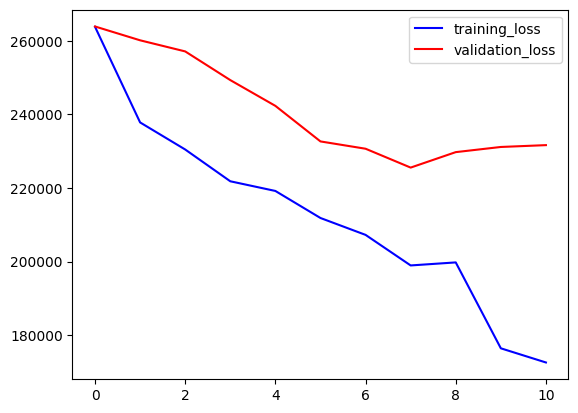

In [ ]:
# set seeds
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


batch_size = 16
train_dataset = WeatherGraphDatasetWithRadar(data, mode="train")
val_dataset = WeatherGraphDatasetWithRadar(data, mode="val")


train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_temporal_graphs,
)
test_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_temporal_graphs,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
training_loss_arr = []
validation_loss_arr = []
early = 0
mini = 450000
stopping_condition = 3
epochs = 0

training_start = time.time()
for i in range(20):
    print(f"-----EPOCH: {i + 1}-----")
    train_loss = train_epoch(model, data, train_loader, optimizer, device)
    validation_loss = validate(model, data, test_loader, device)
    training_loss_arr.append(train_loss)
    validation_loss_arr.append(validation_loss)
    if mini >= validation_loss:
        mini = validation_loss
        early = 0
    else:
        early += 1
    epochs += 1
    if early >= stopping_condition:
        print("Early stop loss")
        break

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}")

training_end = time.time()

print(f"Training took {training_end - training_start} seconds over {epochs} epochs")
plt.plot(training_loss_arr, label="training_loss", color="blue")
plt.plot(validation_loss_arr, label="validation_loss", color="red")
plt.legend()

torch.save(model.state_dict(), "weights/weather_gnn_best.pth")
print("✅ model weights saved to weather_gnn_best.pth")


In [ ]:
print(next(iter(test_loader))["gen_x"].shape)

In [ ]:
total_params = sum(param.numel() for param in model.parameters())
print(total_params)
print(list(param for param in model.parameters()))


In [209]:
def test_model():
    model.eval()
    total_rmse = 0

    plot_preds = np.array([])
    plot_actual = np.array([])

    test_dataset = WeatherGraphDatasetWithRadar(data, mode="val")

    val_gen_mask = torch.tensor(data["general_station"].val_mask, dtype=torch.bool).to(
        device
    )
    val_rain_mask = torch.tensor(
        [0 for _ in data["rainfall_station"].val_mask], dtype=torch.bool
    ).to(device)

    test_gen_mask = torch.tensor(
        data["general_station"].test_mask, dtype=torch.bool
    ).to(device)
    test_rain_mask = torch.tensor(
        data["rainfall_station"].test_mask, dtype=torch.bool
    ).to(device)
    
    train_gen_mask = torch.tensor(
        data["general_station"].train_mask, dtype=torch.bool
    ).to(device)
    train_rain_mask = torch.tensor(
        data["rainfall_station"].train_mask, dtype=torch.bool
    ).to(device)

    print(test_gen_mask)

    edge_index_dict = {key: val.to(device) for key, val in data.edge_index_dict.items()}

    edge_attr_dict = {key: val.to(device) for key, val in data.edge_attr_dict.items()}

    dataloader = DataLoader(
        test_dataset, batch_size=1, shuffle=False, collate_fn=collate_temporal_graphs
    )

    count = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="testing"):
            gen_x = batch["gen_x"].to(
                device
            )  # [batch_size, num_gen_nodes, gen_features]
            rain_x = batch["rain_x"].to(
                device
            )  # [batch_size, num_rain_nodes, rain_features]
            radar_x = batch["radar_x"].to(device)  # Add radar
            gen_y = batch["gen_y"].to(device)
            rain_y = batch["rain_y"].to(device)

            batch_size = gen_x.shape[0]

            batch_rmse = 0
            for i in range(batch_size):
                gen_x_masked = gen_x[i].clone()
                rain_x_masked = rain_x[i].clone()

                gen_x_masked[val_gen_mask] = 0
                rain_x_masked[val_rain_mask] = 0
                gen_x_masked[test_gen_mask] = 0
                rain_x_masked[test_rain_mask] = 0
                x_dict = {
                    "general_station": gen_x_masked,
                    "rainfall_station": rain_x_masked,
                    "radar_grid": radar_x[i],  # Radar is NOT masked
                }

                out = model(x_dict, edge_index_dict, edge_attr_dict)

                gen_predictions = out["general_station"][train_gen_mask]
                rain_predictions = out["rainfall_station"][train_rain_mask]

                gen_targets = gen_y[i][train_gen_mask]
                rain_targets = rain_y[i][train_rain_mask]

                plot_preds = np.concatenate(
                    (
                        plot_preds,
                        gen_predictions.detach().numpy().flatten(),
                        rain_predictions.detach().numpy().flatten(),
                    )
                )
                plot_actual = np.concatenate(
                    (
                        plot_actual,
                        gen_targets.detach().numpy().flatten(),
                        rain_targets.detach().numpy().flatten(),
                    )
                )

                gen_MSE_arr = (gen_predictions - gen_targets) ** 2
                rain_MSE_arr = (rain_predictions - rain_targets) ** 2

                all_squared_errors = torch.cat([gen_MSE_arr, rain_MSE_arr])
                test_rmse = torch.sqrt(torch.mean(all_squared_errors))

                batch_rmse += test_rmse.item()
                count += 1

            total_rmse += batch_rmse

    plt.scatter(x=plot_actual, y=plot_preds)
    plot_bound = max(
        np.nanmax(plot_actual).astype(int), np.nanmax(plot_preds).astype(int)
    )
    plt.plot(np.linspace(0, plot_bound, 100), np.linspace(0, plot_bound, 100))
    plt.xlabel("actual rainfall")
    plt.ylabel("predicted rainfall")

    mask = ~np.isnan(plot_actual)
    pearson_r_global, pearson_p_global = pearsonr(plot_actual[mask], plot_preds[mask])

    print(f"Pearson correlation: {pearson_r_global}")
    return total_rmse / count

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False])


testing: 100%|██████████| 8736/8736 [00:19<00:00, 447.02it/s]


Pearson correlation: 0.703020989247009
TEST RMSE: 203.00356034181274


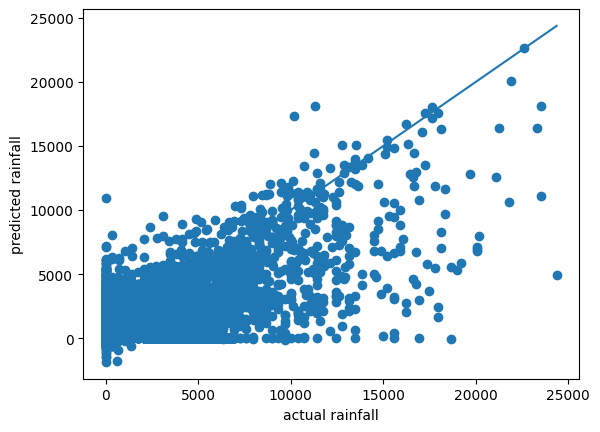

In [210]:
RMSE = test_model()
print(f"TEST RMSE: {RMSE}")

# Visualisation of output
Test event will be 02-05-2025 0415 to 0615


In [217]:
def visualize_one_event(test_event_data, radar_features_event, do_plot=True):
    """
    Prepare a single example from `test_event_data` (a pandas slice like
    weather_station_df_pivot.iloc[593:602]) and run the model for inference.

    This function returns:
      gen_out: numpy array of predicted general_station outputs (shape: [num_gen_nodes, out_features])
      rain_out: numpy array of predicted rainfall_station outputs (shape: [num_rain_nodes, out_features])
    """
    model.eval()

    # clone template (so we keep masks/edge_index/order)
    test_data = data.clone()

    # --- collect station-wise time-series just like you had before ---
    test_general_station_data = {}
    test_rainfall_station_data = {}

    for station in test_event_data.columns.get_level_values(1).unique():
        station_cols = (
            test_event_data.xs(station, level=1, axis=1)
            .interpolate(method="linear")
            .fillna(method="ffill")
            .fillna(method="bfill")
        )
        if station in general_station:
            test_general_station_data[station] = (
                station_cols.values
            )  # shape [T, gen_feat]
        else:
            test_rainfall_station_data[station] = station_cols.values[
                :, 0:1
            ]  # [T, rain_feat=1]

    # Build arrays in the correct node ordering
    gen_feats_list = []
    rain_feats_list = []

    for station in general_station:
        gen_feats_list.append(
            test_general_station_data[station]
        )  # each item: [T, gen_feat_per_t]
    for station in rainfall_station:
        rain_feats_list.append(
            test_rainfall_station_data[station]
        )  # each item: [T, rain_feat_per_t]

    # Convert to numpy arrays and get shapes
    # After np.array(gen_feats_list) => shape [num_gen_nodes, T, gen_feat_per_t]
    gen_arr = np.array(gen_feats_list)  # [N_gen, T, Fg]
    rain_arr = np.array(rain_feats_list)  # [N_rain, T, Fr]

    # --- Convert to the 2-D node-feature format the model expects ---
    # There are different sensible choices here:
    #  - take last timestep: arr[:, -1, :] -> [N, F]
    #  - flatten the time axis into the feature axis: arr.reshape(N, T*F)
    # The training/test collate you used produces per-node features (no time dim).
    # To match that, we flatten time into features (preserves the whole window).
    def flatten_time_axis(arr):
        # arr: [N, T, F]
        N, T, F = arr.shape
        return arr.reshape(N, T * F)  # [N, T*F]

    gen_node_feats = gen_arr[:, -1, :].astype(np.float32)
    rain_node_feats = rain_arr[:, -1, :].astype(np.float32)  # [N, F]
    radar_node_feats = radar_features_event[-1].float()  # [N_radar, F]

    # Convert to torch tensors (2-D per node type) and move to device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    x_dict = {
        "general_station": torch.tensor(
            gen_node_feats, dtype=torch.float, device=device
        ),
        "rainfall_station": torch.tensor(
            rain_node_feats, dtype=torch.float, device=device
        ),
        "radar_grid": torch.tensor(radar_node_feats, dtype=torch.float, device=device),
    }

    # Move edge structures to device (the same ones you used in test_model)
    edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
    edge_attr_dict = {k: v.to(device) for k, v in data.edge_attr_dict.items()}

    # Run model
    with torch.no_grad():
        out = model(x_dict, edge_index_dict, edge_attr_dict)

    # out[...] are torch tensors shaped like [num_nodes, out_features] (depending on your model head)
    gen_out = out["general_station"].cpu().numpy()
    rain_out = out["rainfall_station"].cpu().numpy()

    return gen_out, rain_out


In [218]:
test_event_data = weather_station_df_pivot.iloc[593:602]  # your 9 timestamps
radar_features_event = data['radar_grid'].x[593:602]
gen_out, rain_out = visualize_one_event(test_event_data, radar_features_event)
out_np = np.concatenate([gen_out, rain_out], axis=0)

/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_6640/3144541286.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_event_data.xs(station, level=1, axis=1)
/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_6640/3144541286.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_event_data.xs(station, level=1, axis=1)
/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_6640/3144541286.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_event_data.xs(station, level=1, axis=1)
/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_6640/3144541286.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfil

In [219]:
print(test_data.edge_index_dict)

{('general_station', 'gen_to_rain', 'rainfall_station'): tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,
          4,  5,  5,  5,  5,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9,
         10, 10, 11, 11, 11, 11, 12, 13, 13, 13, 13, 14, 14, 14],
        [16,  1, 17, 19,  6, 13, 29, 18,  8, 42, 24,  9, 27, 28, 32, 31, 30, 47,
         41, 40, 44,  5, 22, 25, 46, 25, 22, 38, 40, 11, 26, 12, 33, 15, 21, 39,
         32, 27, 28, 18, 27, 34, 32,  7, 29, 37, 46, 21, 15, 20]]), ('rainfall_station', 'rain_to_gen', 'general_station'): tensor([[ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 15, 16, 17, 18, 18,
         19, 20, 21, 21, 22, 24, 26, 27, 27, 28, 28, 29, 31, 32, 32, 33, 34, 35,
         36, 40, 42, 44],
        [ 0, 11,  9,  5,  1, 13,  2,  2,  0,  8,  8,  5,  9, 14,  0,  0, 11,  1,
          0, 14, 14,  9,  5,  2,  8,  3, 11, 11,  3, 13,  4,  3, 13,  8, 11,  8,
          0,  5,  2,  5]]), ('general_station', 'gen_to_gen', 'general_station'

# Visualise rain on radar grid
Hard coded to plot only consequitive 9 timestamps

In [220]:
print(out_np / 12)

[[36.95164   ]
 [24.036257  ]
 [38.399616  ]
 [ 4.1853056 ]
 [34.08258   ]
 [        nan]
 [        nan]
 [        nan]
 [37.877304  ]
 [21.809797  ]
 [ 2.043537  ]
 [ 1.6682825 ]
 [ 1.7803793 ]
 [        nan]
 [34.865414  ]
 [15.816377  ]
 [16.70223   ]
 [ 6.296805  ]
 [ 8.8511095 ]
 [ 8.821563  ]
 [16.40761   ]
 [        nan]
 [        nan]
 [ 8.663363  ]
 [25.90956   ]
 [ 9.198989  ]
 [ 9.732144  ]
 [14.565404  ]
 [ 8.574742  ]
 [ 3.6645432 ]
 [29.71335   ]
 [40.83479   ]
 [20.10486   ]
 [ 6.387098  ]
 [39.912792  ]
 [37.242153  ]
 [12.797702  ]
 [        nan]
 [        nan]
 [ 8.663363  ]
 [        nan]
 [ 9.709792  ]
 [-1.2518286 ]
 [19.677229  ]
 [        nan]
 [15.57521   ]
 [37.203423  ]
 [-0.16165291]
 [28.981035  ]
 [20.67058   ]
 [ 9.979001  ]
 [ 9.903777  ]
 [        nan]
 [        nan]
 [14.710861  ]
 [        nan]
 [14.092458  ]
 [40.2925    ]
 [ 9.955753  ]
 [        nan]
 [ 6.235393  ]
 [        nan]
 [39.355835  ]]


# Visualize Radar Image

The size of dataset is 8334
Data shape: (327, 327)
Data min: -0.1577209085226059, max: 99.19561004638672, mean: 1.1949541568756104
Non-zero values: 23665 out of 106929


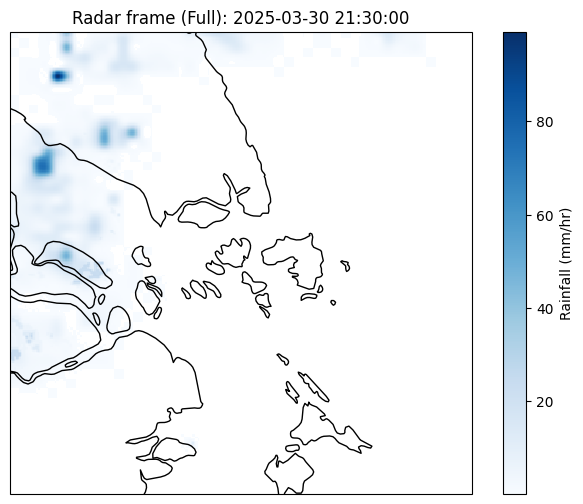

In [ ]:
radar_df = load_radar_dataset("sg_radar_data")

visualize_one_radar_image(radar_df=radar_df)

IndexError: index 1 is out of bounds for axis 0 with size 1

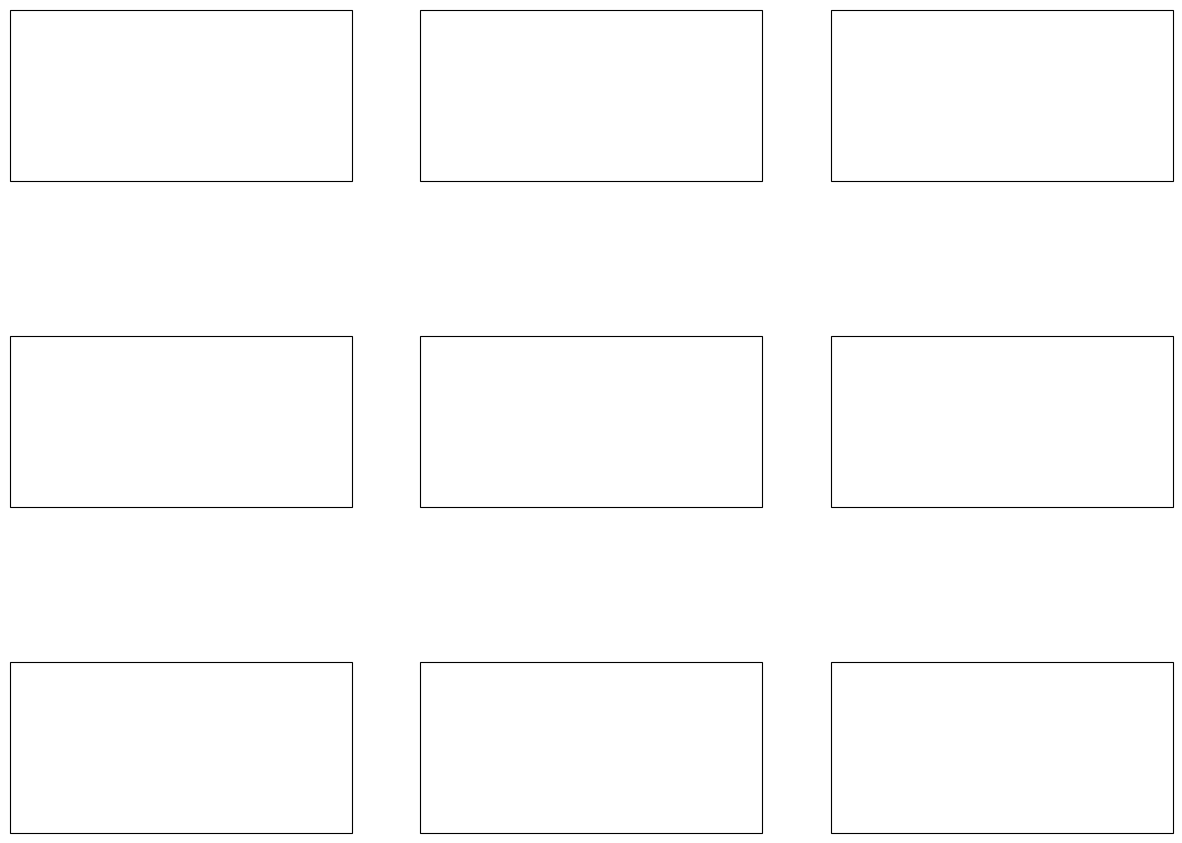

In [ ]:
# fig, ax = plt.subplots(
#     3, 3, figsize=(15, 12), subplot_kw={"projection": ccrs.PlateCarree()}
# )

# out_np = out_np / 12
# for idx, timestamp in enumerate(out_np):
#     output = {}
#     count = 0

#     for stn in general_station:
#         output[stn] = float(timestamp[count])
#         count += 1
#     for stn in rainfall_station:
#         output[stn] = float(timestamp[count])
#         count += 1
#     axi = ax[idx // 3][idx % 3]
#     node_df = pd.Series(output)
#     node_df = pandas_to_geodataframe(node_df)
#     visualise_gauge_grid(node_df=node_df, ax=axi)
#     improved_visualise_radar_grid(
#         radar_df.iloc[idx], ax=axi, zoom=bounds_singapore, norm=norm
#     )
#     visualise_singapore_outline(ax=axi)

In [224]:
original_rainfall_rates = (
    weather_station_df_pivot.iloc[1773:1797].resample("15min").first()["rain_rate"]
)


print(original_rainfall_rates)

gid                     S06      S07          S08  S102  S104    S106   S107  \
time_sgt                                                                       
2025-02-17 11:15:00     0.0      0.0      0.00000   NaN   NaN     0.0    0.0   
2025-02-17 11:30:00     0.0      0.0      0.00000   NaN   NaN     0.0    0.0   
2025-02-17 11:45:00     0.0      0.0      0.00000   NaN   NaN     0.0    0.0   
2025-02-17 12:00:00     0.0      0.0      0.00000   NaN   NaN     0.0    0.0   
2025-02-17 12:15:00     0.0      0.0      0.00000   NaN   NaN     0.0    0.0   
2025-02-17 12:30:00     0.0      0.0      0.00000   NaN   NaN     0.0    0.0   
2025-02-17 12:45:00     0.0      0.0      0.00000   NaN   NaN     0.0    0.0   
2025-02-17 13:00:00     0.0      0.0      0.00000   NaN   NaN     0.0    0.0   
2025-02-17 13:15:00     0.0      0.0      0.00000   NaN   NaN     0.0  345.6   
2025-02-17 13:30:00     0.0      0.0      0.00000   NaN   NaN     0.0    0.0   
2025-02-17 13:45:00     0.0      0.0    

In [225]:
print(out)

NameError: name 'out' is not defined

In [ ]:
actual_arr = []
pred_arr = []

for idx, timestamp in enumerate(out):
    output = {}
    count = 0
    a_arr = []
    p_arr = []

    for stn in general_station:
        output[stn] = float(timestamp[count])
        count += 1
    for stn in rainfall_station:
        output[stn] = float(timestamp[count])
        count += 1

    for key, value in output.items():
        a_arr.append(original_rainfall_rates.iloc[idx][key])
        p_arr.append(output[key])
    a_arr = list(map(lambda x: float(x), a_arr))
    actual_arr.append(a_arr)
    pred_arr.append(p_arr)

actual_arr = np.array(actual_arr)
pred_arr = np.array(pred_arr)

print(actual_arr)
print(pred_arr)
error = []
for i in range(len(actual_arr)):
    error.append(np.nanmean(actual_arr - pred_arr) ** 2)

MSE = np.mean(np.array(error))
print(MSE)


In [ ]:
print(original_rainfall_rates.iloc[0])